In [3]:
import pygmt
import numpy as np
import pandas as pd
import geopy.distance

In [121]:
#Some initialzation for pyGMT
# define the map (study) extents
min_lon = -82
max_lon = -66
min_lat = -5
max_lat = 14
# read in the topograpy for generating background map
grid = pygmt.datasets.load_earth_relief(region=[min_lon,max_lon,min_lat,max_lat],resolution='15s')

In [115]:
colombia_stations = 'Colombia-Noise.csv'
ecuador_stations = 'Ecuador-Noise.csv'

In [116]:
# Read in station locations and noise for each station
dfE = pd.read_csv(ecuador_stations)
dfC = pd.read_csv(colombia_stations)
frames = [dfC, dfE ]
df = pd.concat(frames)

In [104]:
#Bogota, Medillin, Cali, Barranquilla, Cartagena
cities = [[4.7110, -74.0721],
          [6.2476, -75.5658],
          [3.4516, -76.5320],
          [11.0041, -74.8070],
          [10.3932, -75.4832]]

In [ ]:
# November 19, 1991 M7.2
# November 15, 2004 M7.2
# 
eqs = [[4.80, -77.18],
       [4.72, -77.57]]

In [114]:
#November 19, 1991 M7.2
eq_loc = eqs[0]
city_loc = cities[2]
#minimum number of stations for detection
min = 4
#Seimic velocity in km/sec
vel = 4

In [117]:
df['distance']   = df.apply(lambda row: geopy.distance.geodesic( eq_loc,(row.lat,row.lon)).km, axis=1)
df.sort_values(by='distance', inplace=True, ignore_index=True)

In [118]:
city_dist = geopy.distance.geodesic(eq_loc,city_loc).km 
dect_dist = df.loc[min-1,'distance']
warning_time_sec = (city_dist - dect_dist)/vel

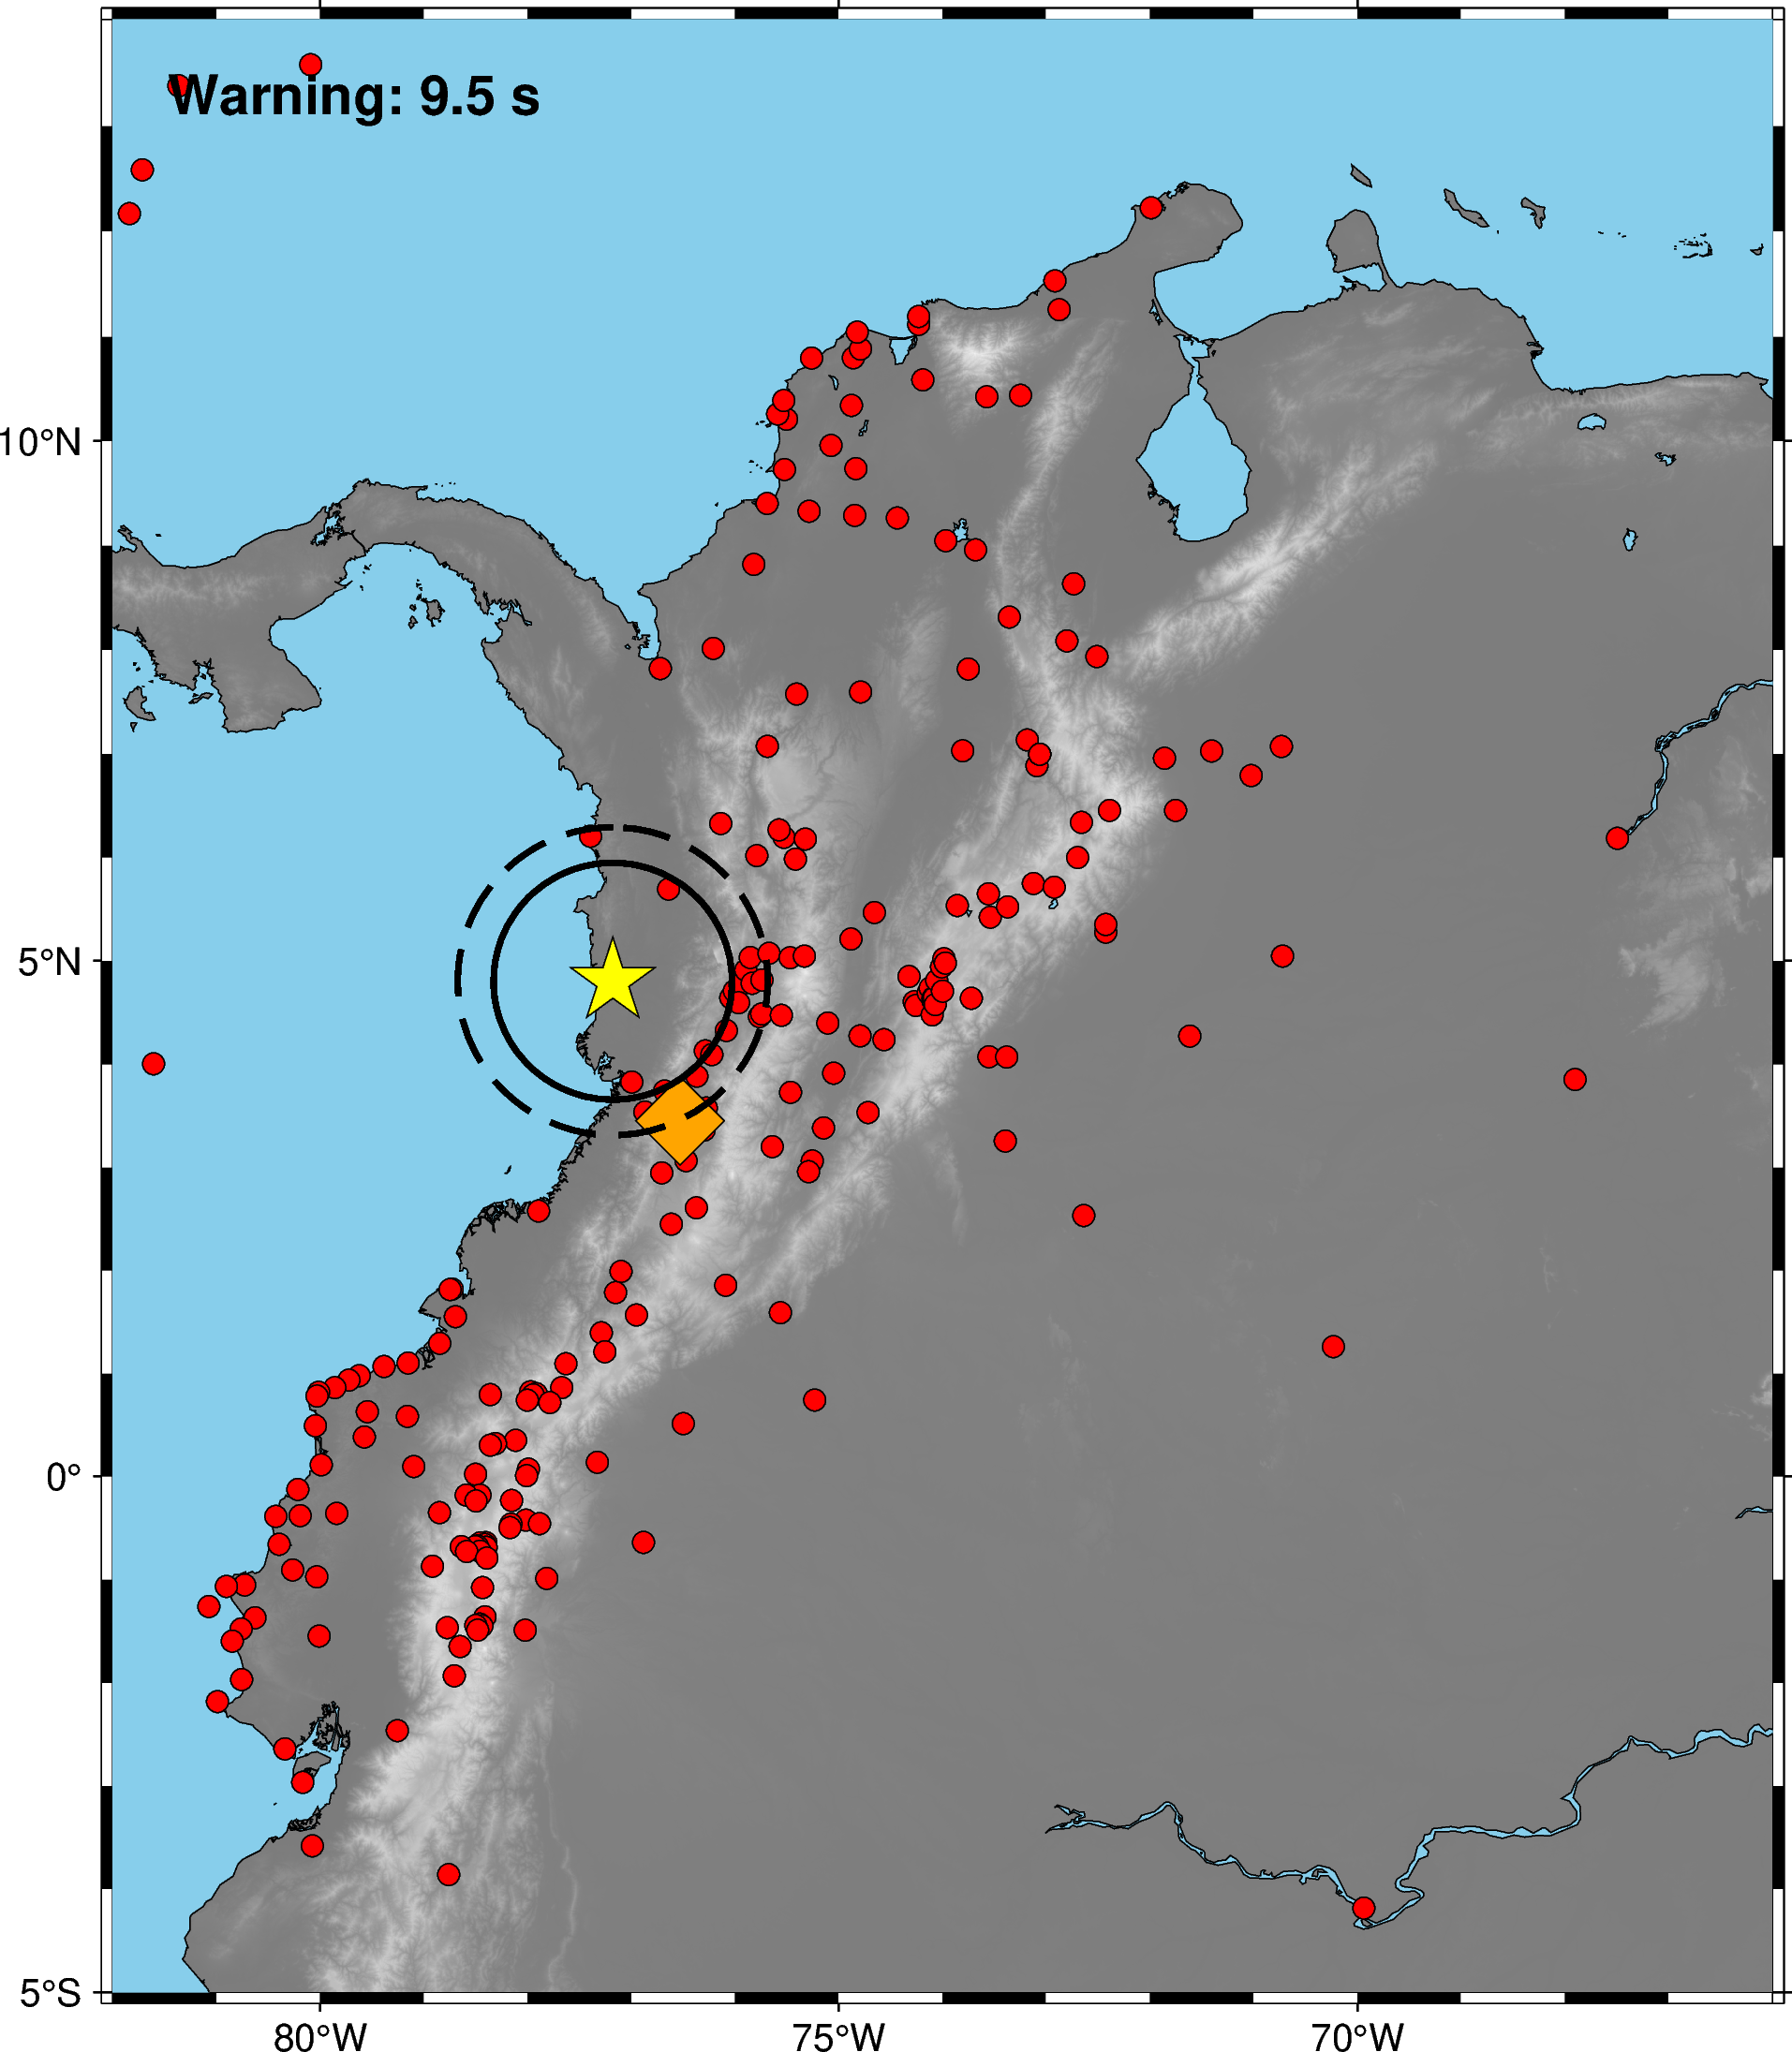

In [120]:
# Build figure using pyGMT
projection = "M-71.5/8/15c"
label= "Warning: " + "{:.1f}".format(warning_time_sec) + " s"
fig = pygmt.Figure()
fig.basemap(projection=projection, region=[min_lon,max_lon,min_lat,max_lat], frame=True)
fig.grdimage(grid=grid,cmap="gray")
fig.coast(shorelines=True, water="skyblue")
#plot the sites
fig.plot(x=df.lon, y=df.lat, style="c0.2c", color="red", pen="black")
#plot the earthquake
fig.plot(x=eq_loc[1], y=eq_loc[0], style="a.8c", color="yellow", pen="black")
#plot the city
fig.plot(x=city_loc[1], y=city_loc[0], style="d.8c", color="orange", pen="black")
# plot the detection radius
fig.plot(x=eq_loc[1], y=eq_loc[0], style="E0/"+"{:.1f}".format(dect_dist*2)+"/"+"{:.1f}".format(dect_dist*2), pen="thicker,black,solid")
#plot radius when eq hits city
fig.plot(x=eq_loc[1], y=eq_loc[0], style="E0/"+"{:.1f}".format(city_dist*2)+"/"+"{:.1f}".format(city_dist*2), pen="thicker,black,dashed")
fig.text(text=label, position="LT", offset=".5c/-.5c", font="14p,Helvetica-Bold,black")
fig.show()